## Confirm access to a GPU

In [1]:
!nvidia-smi

Sat Feb 17 18:45:13 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Getting data

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [3]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [4]:
# start the expriments with 20K of the dataset with numbers replaced by '@' sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign"

In [5]:
# Check all of the filenames in the target directory
import os
for dirpath, dirname, filepath in os.walk('/content/pubmed-rct'):
  print(f"There are {len(filepath)} files and {len(dirname)} directories in the file path {dirpath}")

There are 1 files and 5 directories in the file path /content/pubmed-rct
There are 3 files and 0 directories in the file path /content/pubmed-rct/PubMed_200k_RCT
There are 3 files and 0 directories in the file path /content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign
There are 3 files and 0 directories in the file path /content/pubmed-rct/PubMed_20k_RCT
There are 3 files and 0 directories in the file path /content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign
There are 5 files and 6 directories in the file path /content/pubmed-rct/.git
There are 0 files and 3 directories in the file path /content/pubmed-rct/.git/refs
There are 0 files and 0 directories in the file path /content/pubmed-rct/.git/refs/tags
There are 0 files and 1 directories in the file path /content/pubmed-rct/.git/refs/remotes
There are 1 files and 0 directories in the file path /content/pubmed-rct/.git/refs/remotes/origin
There are 1 files and 0 directories in the file path /content/pubmed-rct/.g

In [6]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signtest.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signtrain.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signdev.txt']

## Preprocess data

In [7]:
# Create function to read the lines of a document
def get_lines(filename):
 """
 Read the filename (a text fielname and areturn the lines of text as a list
 Args:
  fielname: a string sontaining the target filepath
 Returns:
  A list of strings with one string per line aform the target filename
  """
 with open(filename, "r") as f:
    return f.readlines()

In [8]:
train_lines = get_lines(os.path.join(data_dir, "train.txt"))

In [9]:
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [10]:
len(train_lines)

210040

How we want our data to look.

how you think the data would be represented
```
[{line_number: 0,
  'target': 'BACKGROUND',
  'text': 'xyz.\n',
  'total_lines': 11}
  ...
  ]'

```

In [11]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data..

  Takes in filename, reads it contennts and sorts through each line extracting things like
  the target label, the text of the sentence, how many sentences are in the current abstract
  and what sentence number the target line is.
  """
  input_lines = get_lines(filename) # get all the lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()

      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line
        target_text_split = abstract_line.split("\t")
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_line_split)
        abstract_samples.append(line_data)

    else:
      abstract_lines += line

  return abstract_samples

In [12]:
%%time
train_samples = preprocess_text_with_line_numbers(os.path.join(data_dir, "train.txt"))
val_samples = preprocess_text_with_line_numbers(os.path.join(data_dir, "dev.txt"))
test_samples = preprocess_text_with_line_numbers(os.path.join(data_dir, "test.txt"))
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 744 ms, sys: 158 ms, total: 902 ms
Wall time: 1.37 s


(180040, 30212, 30135)

In [13]:
# Check first abstract of our training data
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Now the data is in the format of a list of dictionaries.
So now we should turn the data into pandas DataFrame and further visualize the data.

In [14]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(42)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,12
1,METHODS,a total of @ patients with primary knee oa wer...,1,12
2,METHODS,outcome measures included pain reduction and i...,2,12
3,METHODS,pain was assessed using the visual analog pain...,3,12
4,METHODS,secondary outcome measures included the wester...,4,12
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,12
6,RESULTS,there was a clinically relevant reduction in t...,6,12
7,RESULTS,the mean difference between treatment arms ( @...,7,12
8,RESULTS,"further , there was a clinically relevant redu...",8,12
9,RESULTS,these differences remained significant at @ we...,9,12


In [15]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<Axes: >

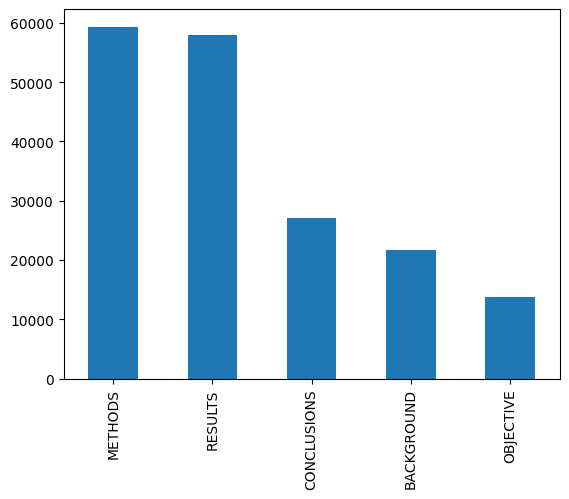

In [16]:
train_df.target.value_counts().plot(kind = "bar")

<Axes: ylabel='Frequency'>

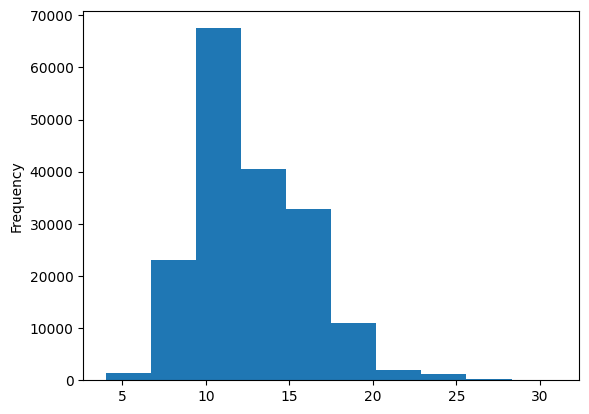

In [17]:
train_df.total_lines.plot.hist()

### Get list of sentences

In [18]:
# Convert abstract text line into lists
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()

In [19]:
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [20]:
# View the 10 liens of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels

In [21]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse = False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1, 1))
train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [22]:
import tensorflow as tf
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

# Label encoding the labels

In [23]:
# Extrating lables ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [24]:
# Get class names and number of classes form LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Making different models

## Model 0: Making a Baseline model

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ('clf', MultinomialNB())
])

model_0.fit(X = train_sentences,
            y = train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [26]:
# Evlauate baseline model on validation dtaaset
model_0.score(X = val_sentences,
                 y = val_labels_encoded)

0.7218323844829869

In [27]:
# Making prediction using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [28]:
val_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

## Download the helper function script

In [29]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-02-17 18:45:32--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-02-17 18:45:33 (96.2 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [30]:
from helper_functions import calculate_results
baseline_results = calculate_results(y_true = val_labels_encoded,
                                     y_pred = baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing the data for deep sequence models

Before we start building deeper models, we've got to create vectorization and embedding layers.

In [31]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [32]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [33]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len
min_sent = np.min(sent_lens)
max_sent = np.max(sent_lens)
min_sent, max_sent, avg_sent_len

(1, 296, 26.338269273494777)

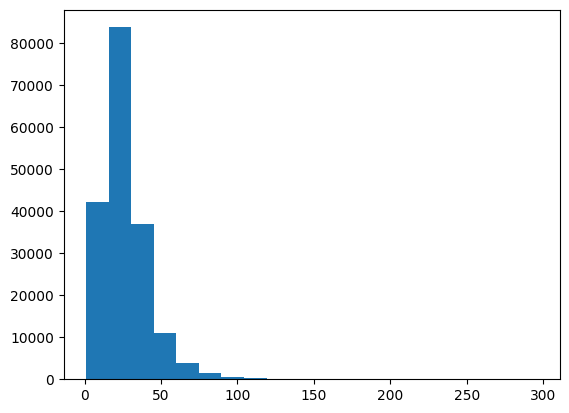

In [34]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins = 20);

In [35]:
# How long of a sentence length contains the 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

### creating a text vectorizer layer
we want to make a layer which maps our texts from words to number.

In [36]:
# How many words are in the vocab?
max_tokens = 68000

In [37]:
# Create text vectorizer
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens = max_tokens,
                                    output_sequence_length = output_seq_len)

In [38]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [39]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text: {target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text: to determine if a stabilised , stannous-containing sodium fluoride dentifrice provides greater enamel protection in situ against intraoral dietary erosive challenges compared with a sodium fluoride/potassium nitrate dentifrice .

Length of text: 29

Vectorized text: [[    6   228   324     8 12945 19549   764  2527  3287   828   182  4205
   1412     5  3961   644  8046   566 10764  2292    34     7     8   764
  31266  3773  3287     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [40]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
# rct_20k_text_vocab
print(f"Number of words in the vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in the vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [41]:
 text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Crate custom text embedding

In [42]:
token_embed = layers.Embedding(input_dim = len(rct_20k_text_vocab),
                               output_dim = 128,
                               mask_zero = True,
                               name = "token_embedding")


In [43]:
# Show exaple embedding
print(f"Sentence before vecotrization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"sentece after vectorizetion(before embedding): \n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"sentence after embedding: \n { embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vecotrization:
 to determine if a stabilised , stannous-containing sodium fluoride dentifrice provides greater enamel protection in situ against intraoral dietary erosive challenges compared with a sodium fluoride/potassium nitrate dentifrice .

sentece after vectorizetion(before embedding): 
 [[    6   228   324     8 12945 19549   764  2527  3287   828   182  4205
   1412     5  3961   644  8046   566 10764  2292    34     7     8   764
  31266  3773  3287     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

sentence after embedding: 
 [[[ 0.0282406  -0.0356619  -0.0062736  ...  0.04855527 -0.03729771
    0.0293304 ]
  [ 0.03505192 -0.00518132  0.00198821 ...  0.04980823  0.01484629
   -0.01546271]
  [ 0.04522265 -0.0220719  -0.04739751 ... -0.00577718 -0.02412118
   -0.01501486]
  ...
  [ 0.03522105 -0.03778813  0.03318029 ...  0.04151935 -0.00244

## Creating datasets(making sure that our data loads as fast as possible)

We make sure that the our data runs as fast as possible with Tensorflow using the tf.data API

In [44]:
# Turn our data into TensorFlow Datasets

train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [45]:
# take the TensorSliceDateset's and turn them into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [46]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

In [47]:
# Create 1D conv model to process sequences
inputs = layers.Input(shape = (1, ), dtype = tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size = 5, padding = "same", activation = 'relu')(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector from conv layer
outputs = layers.Dense(num_classes, activation = 'softmax')(x)
model_1 =tf.keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [48]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                             

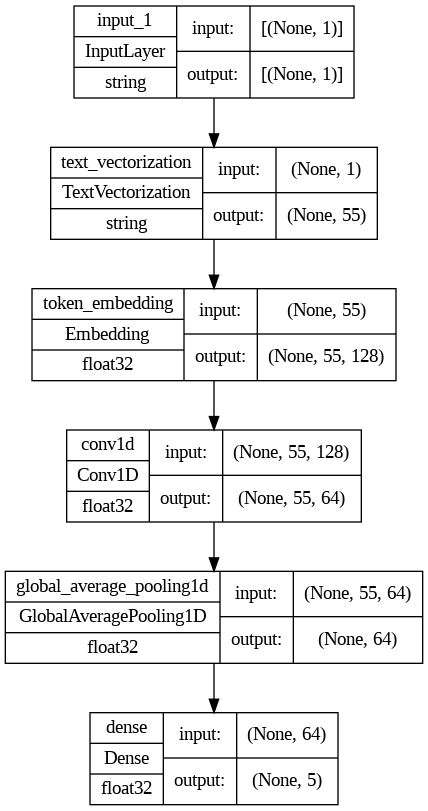

In [49]:
from tensorflow.keras.utils import plot_model
plot_model(model_1, show_shapes = True, show_dtype = True, expand_nested = True)

In [50]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch = int(0.1*len(train_dataset)),
                              epochs = 3,
                              validation_data = valid_dataset,
                              validation_steps = int(0.1 * (len(valid_dataset))))

Epoch 1/3
562/562 [==============================] - 21s 33ms/step - loss: 0.9192 - accuracy: 0.6359 - val_loss: 0.6901 - val_accuracy: 0.7330
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6660 - accuracy: 0.7519 - val_loss: 0.6339 - val_accuracy: 0.7696
Epoch 3/3
562/562 [==============================] - 5s 8ms/step - loss: 0.6286 - accuracy: 0.7687 - val_loss: 0.6058 - val_accuracy: 0.7812


In [51]:
# Evaluate on the whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.6111 - accuracy: 0.7814


[0.6110889911651611, 0.7814444303512573]

In [52]:
# make predictions (our model predicts prediction probabilitites for each class)
model_1_pred_probs = model_1.predict(valid_dataset)

945/945 [==============================] - 2s 2ms/step


In [53]:
model_1_pred_probs, model_1_pred_probs.shape

(array([[4.03492242e-01, 2.08975777e-01, 1.03904895e-01, 2.48383909e-01,
         3.52431871e-02],
        [4.35747474e-01, 2.92374730e-01, 1.08639346e-02, 2.54077613e-01,
         6.93625584e-03],
        [1.56238690e-01, 1.47570008e-02, 2.66720052e-03, 8.26285481e-01,
         5.15834035e-05],
        ...,
        [3.04806508e-06, 9.72494076e-04, 7.01276993e-04, 7.00345254e-07,
         9.98322427e-01],
        [6.64162189e-02, 4.52598065e-01, 1.03625327e-01, 8.16537812e-02,
         2.95706630e-01],
        [2.15259090e-01, 5.38759351e-01, 4.34790924e-02, 7.51150921e-02,
         1.27387345e-01]], dtype=float32),
 (30212, 5))

In [54]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis = 1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [55]:
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [56]:
# Calculate model_1 resutls
model_1_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_1_preds)
model_1_results

{'accuracy': 78.14444591553026,
 'precision': 0.778012903558963,
 'recall': 0.7814444591553026,
 'f1': 0.7788935791906054}

In [57]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 2: Feature extraction with pretrained token embeddings

In [61]:
import tensorflow_hub as hub

tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable = False,
                                        name='universal_sentence_encoder')


In [64]:
# Test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence: \n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentece after embedding: {use_embedded_sentence[0][:30]}")
print(f"Lenght fo sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence: 
 natural products like turmeric and cinnamon may ameliorate the underlying pathogenesis .
Sentece after embedding: [-0.00039813  0.04718187  0.03456117 -0.03832823 -0.01873522  0.02086463
  0.03852127 -0.01012286  0.04064678  0.07851382  0.02431967  0.03135699
  0.01115754  0.02606475 -0.09088095 -0.03572126 -0.03922807 -0.06284893
  0.03095905 -0.03548565 -0.00132102  0.06351804 -0.044697    0.00657212
  0.04156181  0.07346003  0.05827129  0.02862012  0.04641579 -0.00326191]
Lenght fo sentence embedding: 512


## Building and fitting an NLP feature extraction model model

In [69]:
# Define feaure extraction model using kaggle model layer
inputs = layers.Input(shape = [], dtype = tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embeddign of each sequence (512)
x = layers.Dense(128, activation = 'relu')(pretrained_embedding)
outputs = layers.Dense(5, activation = "softmax")(x)
model_2 = tf.keras.Model(inputs = inputs,
                         outputs = outputs,
                         name = 'model_2_USE_feature_extractor')

# Compile the model
model_2.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [70]:
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_3 (Dense)             (None, 128)               65664     
                                                                 
 dense_4 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


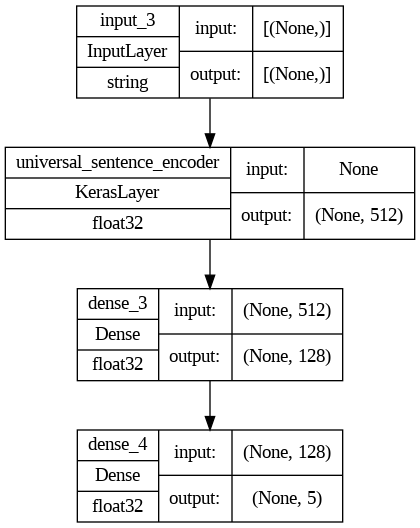

In [72]:
plot_model(model_2, show_dtype = True, show_shapes = True, expand_nested = True)

In [74]:
# Fit model_2 to the data
history_model_2 = model_2.fit(train_dataset,
                              epochs = 3,
                              steps_per_epoch = int(0.1 * len(train_dataset)),
                              validation_data = valid_dataset,
                              validation_steps = int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 12s 13ms/step - loss: 0.9195 - accuracy: 0.6486 - val_loss: 0.7973 - val_accuracy: 0.6882
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7674 - accuracy: 0.7022 - val_loss: 0.7545 - val_accuracy: 0.7048
Epoch 3/3
562/562 [==============================] - 9s 17ms/step - loss: 0.7498 - accuracy: 0.7127 - val_loss: 0.7370 - val_accuracy: 0.7164


In [75]:
# Evaluate on the whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 16s 17ms/step - loss: 0.7391 - accuracy: 0.7140


[0.7390637993812561, 0.713954746723175]

In [76]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 14s 14ms/step


array([[4.6029145e-01, 3.1588045e-01, 2.6778392e-03, 2.1158998e-01,
        9.5603084e-03],
       [3.4041575e-01, 5.0721335e-01, 3.6168133e-03, 1.4415081e-01,
        4.6032663e-03],
       [2.2903335e-01, 1.4964484e-01, 2.0820498e-02, 5.6629485e-01,
        3.4206528e-02],
       ...,
       [1.7194266e-03, 6.2998766e-03, 5.1368840e-02, 7.4964762e-04,
        9.3986225e-01],
       [3.7552544e-03, 5.2234381e-02, 2.0309195e-01, 1.3164256e-03,
        7.3960197e-01],
       [1.6079397e-01, 2.3771156e-01, 5.5004281e-01, 5.7112006e-03,
        4.5740392e-02]], dtype=float32)

In [79]:
# Convert the prediction probabilities found with feature extraction model to labels
model_2_preds = tf.argmax(model_2_pred_probs, axis = 1)

In [80]:
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [82]:
# Calculate results from TF Hub pretrained embeddings results on val set
model_2_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_2_preds)

In [83]:
model_2_results

{'accuracy': 71.39547199788163,
 'precision': 0.7146259903075257,
 'recall': 0.7139547199788163,
 'f1': 0.7110647539270222}

In [84]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 3: Conv1D with character embeddings
